# Bookworm


## Overview

In this project, you will build a simple question-answering agent that is able to learn from any text data you provide, and answer queries posed in natural language. You will use IBM Watson's cloud-based services to process the input text data and find relevant responses.

## Learning Objectives

By completing this project, you will learn how to:

- Create a cloud-based NLP service instance and configure it.
- Ingest a set of text documents using the service and analyze the results.
- Accept questions in natural language and parse them.
- Find relevant answers from the preprocessed text data.

## Getting Started

In order to use Watson's cloud-based services, you first need to create an account on the [IBM Bluemix platform](https://console.ng.bluemix.net/).

<div>
    <div style="display: table-cell; width: 50%;">
        <img src="images/watson-logo.png" alt="IBM Watson logo" width="200" />
    </div>
    <div style="display: table-cell; width: 50%;">
        <img src="images/bluemix-logo.png" alt="IBM Bluemix logo" width="400" />
    </div>
</div>

Then, for each service you want to use, you have to create an instance of that service. You can continue with the tasks below, and create a service instance when indicated.

## 1. Create and configure Discovery service

Create an instance of the **Discovery** service. You will use this to process a set of text documents, and _discover_ relevant facts and relationships.

- Go to the [IBM Bluemix Catalog](https://console.ng.bluemix.net/catalog/?taxonomyNavigation=services&category=watson).
- Select the service you want, **Discovery**, under the **Watson** category.
- Enter a Service Name for that instance, e.g. **Disco1** and a Credential Name, e.g. **Disco1-Creds** (these are just for you to be able to refer to later, they do not affect the functioning of the service).
- You should be able to see your newly-created service in your [Services Dashboard](https://console.ng.bluemix.net/dashboard/services).
- Open the service instance, click on the **Service credentials** tab, and then **View credentials** under Actions. This is where you will find the username and password to use when connecting to the service.

<img src="images/discovery-creds.png" alt="Discovery Service - Credentials tab" width="800" />

Save the credentials for the discovery service in a JSON file in the current directory named `service-credentials.json` with the following format:

```json
{
    "discovery": {
        "username": "<your Discovery username here>",
        "password": "<your Discovery password here>"
    },
    "conversation": {
        "username": "",
        "password": ""
    }
}

```

You will be filling out the Conversation service credentials later, when you create an instance for it. Note that you should keep these credentials secret. Please do not turn them in with your submission!

### Connect to the service instance

Let's connect to the service instance you just created using IBM Watson's [Python SDK](https://github.com/watson-developer-cloud/python-sdk). You will first need to install the SDK:
```bash
pip install watson-developer-cloud
```

Now execute each code cell below using **`Shift+Enter`**, and complete any steps indicated by a **`TODO`** comment. For more information on the Discovery service, please read the [Documentation](https://www.ibm.com/watson/developercloud/doc/discovery/index.html) and look at the [API Reference](https://www.ibm.com/watson/developercloud/discovery/api/v1/?python) as needed.

In [87]:
# Usual Python imports
import sys
import os
import glob
import json

# BeautifulSoup, for parsing HTML
from bs4 import BeautifulSoup

# Matplotlib, for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Watson Python SDK
import watson_developer_cloud

# Utility functions
import helper

In [88]:
# Connect to the Discovery service instance
# TODO: Ensure that your username and password from the Service Credentials tab are in service-credentials.json
# Note that these credentials are different from your IBM Bluemix login, and are specific to the service instance
discovery_creds = helper.fetch_credentials('discovery')
discovery = watson_developer_cloud.DiscoveryV1(
    version='2016-11-07',
    username=discovery_creds['username'],
    password=discovery_creds['password'])

### Create an environment

The Discovery service organizes everything needed for a particular application in an _environment_. Let's create one called "Bookworm" for this project.

> _**Note**: It is okay to run this block multiple times - it will not create duplicate environments with the same name._

In [89]:
# Prepare an environment to work in
env, env_id = helper.fetch_object(
    discovery, "environment", "Bookworm",
    create=True, create_args=dict(
        description="A space to read and understand stories",  # feel free to edit
        size=0  # use 0 for free plan (see API reference for more on sizing)
    ))
print(json.dumps(env, indent=2))

Found environment: Bookworm (abac578c-a060-447e-ae61-6adb242a076c)
{
  "environment_id": "abac578c-a060-447e-ae61-6adb242a076c",
  "name": "Bookworm",
  "description": "A space to read and understand stories",
  "created": "2017-07-08T13:42:28.174Z",
  "updated": "2017-07-08T13:42:28.174Z",
  "status": "active",
  "read_only": false,
  "size": 0,
  "index_capacity": {
    "disk_usage": {
      "used_bytes": 0,
      "total_bytes": 4294967296,
      "used": "0 KB",
      "total": "4 GB",
      "percent_used": 0.0
    },
    "memory_usage": {
      "used_bytes": 240353104,
      "total_bytes": 1056309248,
      "used": "229.22 MB",
      "total": "1007.38 MB",
      "percent_used": 22.75
    }
  }
}


### Verify configuration options

A _configuration_ defines what natural language processing routines are applied to any documents that are submitted to the service. Each environment gets a default configuration when it is created.

You can fetch the default configuration and view the different options using the following piece of code.


In [90]:
# View default configuration
cfg_id = discovery.get_default_configuration_id(environment_id=env_id)
cfg = discovery.get_configuration(environment_id=env_id, configuration_id=cfg_id)
print(json.dumps(cfg, indent=2))

{
  "configuration_id": "e957aed2-f980-47b9-a995-89a804042300",
  "name": "Default Configuration",
  "description": "The configuration used by default when creating a new collection without specifying a configuration_id.",
  "created": "2017-07-08T13:42:28.211Z",
  "updated": "2017-07-08T13:42:28.211Z",
  "conversions": {
    "word": {
      "heading": {
        "fonts": [
          {
            "level": 1,
            "min_size": 24,
            "bold": false,
            "italic": false
          },
          {
            "level": 2,
            "min_size": 18,
            "max_size": 23,
            "bold": true,
            "italic": false
          },
          {
            "level": 3,
            "min_size": 14,
            "max_size": 17,
            "bold": false,
            "italic": false
          },
          {
            "level": 4,
            "min_size": 13,
            "max_size": 13,
            "bold": true,
            "italic": false
          }
        ],
    

There are 3 main configuration blocks that affect how input documents are processed:
 
1. **`conversions`**: How to convert documents in various formats (Word, PDF, HTML) and extract elements that indicate some structure (e.g. headings).
2. **`enrichments`**: What NLP output results are we interested in (keywords, entities, sentiment, etc.).
3. **`normalizations`**: Post-processing steps to be applied to the output. This can be left empty in most cases, unless you need the output to be normalized into a very specific format.

_**Note**: The default configuration for an environment cannot be modified. If you need to change any of the options, you will need to create a new one, and then edit it. The easiest way to do this is using the service dashboard, which is described later._

### Test your configuration

It is a good idea to test your configuration on a small sample text before you apply it to a larger document collection.

_**Note**: We have supplied a sample document (`data/sample.html`) containing the opening crawl text for Star Wars: Episode IV, but you are free to use a text of your choosing._

**Q**: (optional) If you use your own sample text, provide a brief title and description below.

**A**: 

In [91]:
# Test configuration on some sample text
data_dir = "data"
filename = os.path.join(data_dir, "sample.html")
with open(filename, "r") as f:
    res = discovery.test_document(environment_id=env_id, configuration_id=cfg_id, fileinfo=f)
print(json.dumps(res, indent=2))

{
  "status": "completed",
  "enriched_field_units": 1,
  "original_media_type": "text/html",
  "snapshots": [
    {
      "step": "html_input",
      "snapshot": {
        "html": "<html>\n<head>\n    <title>Star Wars: Episode IV - A New Hope (Opening Crawl)</title>\n</head>\n<body>\n    <article>\n        <h1>Star Wars: Episode IV - A New Hope (Opening Crawl)</h1>\n        <p>\n            It is a period of civil war. Rebel spaceships, striking from a hidden base, have won their first victory against the evil Galactic Empire.\n        </p><p>\n            During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.\n        </p><p>\n            Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can save her people and restore freedom to the galaxy...\n        </p>\n    </article>\n</body>"
     

### Analyze test output

The results returned by the service contain a _snapshot_ of the information extracted at each step of processing - document conversions, enrichments and normalizations. We are interested in the output of applying enrichments (`"enrichments_output"`) or after normalizing them (`"normalizations_output"`). These should be identical if no post-processing/normalizations were specified in the configuration.

In [92]:
# Take a closer look at the results from the "enrichments_output" or "normalizations_output" step
output = next((s["snapshot"] for s in res["snapshots"] if s["step"] == "enrichments_output"), None)
print(json.dumps(output, indent=2))

{
  "extracted_metadata": {
    "title": "Star Wars: Episode IV - A New Hope (Opening Crawl)"
  },
  "html": "<?xml version='1.0' encoding='UTF-8' standalone='yes'?><html>\n<head>\n    <meta content=\"text/html; charset=UTF-8\" http-equiv=\"Content-Type\"/>\n    \n    <title>Star Wars: Episode IV - A New Hope (Opening Crawl)</title>\n\n\n</head>\n<body>\n\n\n    <article>\n        <h1>Star Wars: Episode IV - A New Hope (Opening Crawl)</h1>\n        <p>\n            It is a period of civil war. Rebel spaceships, striking from a hidden base, have won their first victory against the evil Galactic Empire.\n        </p><p>\n            During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.\n        </p><p>\n            Pursued by the Empire's sinister agents, Princess Leia races home aboard her starship, custodian of the stolen plans that can save her people and res

Answer the following questions based on the output above. Note that it contains the input HTML, extracted text and metadata as well as the actual enrichment results (`"enriched_text"` block).

#### Sentiment

**Q**: What is the overall sentiment detected in this text? Mention the `type` (positive/negative) and `score`.<br />
(_Hint: Look for the `"docSentiment"` key in the output._)

**A**: 
type: negative score: -0.575489

#### Concepts

**Q**: List 3 concepts that have been identified with a relevance > 0.5. Note that not all concepts here may be present directly in the text, some may have been inferred by Watson.<br />
(_Hint: Look for `"concepts"`._)

**A**:
1. text: Star Wars Episode IV: A New Hope -- relevance: 0.98887
2. text: Star Wars -- relevance: 0.985705
3. text: Rebel Alliance -- relevance: 0.90639

#### Relations

Each relation is essentially a deeper analysis of a sentence (or part of a sentence). Here is a sample relation:
```json
{
  "sentence": " During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.",
  "subject": {
    "text": "Rebel spies",
    "keywords": [
      {
        "text": "Rebel spies"
      }
    ]
  },
  "action": {
    "text": "managed to steal",
    "lemmatized": "manage to steal",
    "verb": {
      "text": "steal",
      "tense": "future"
    }
  },
  "object": {
    "text": "secret plans",
    "keywords": [
      {
        "text": "secret plans"
      }
    ]
  }
 }
```

In this case, Watson seems to have done a pretty good job of extracting some meaning from the sentence.

**Q**: Find a relation where the extracted meaning is not as accurate, or not what you would've expected. List the `sentence`, `subject`, `action` and `object` parts as identified, and what you would've marked instead.<br />
(_Hint: Look for `"relations"`._)

**A**: 
The following relation is not what I expect

`"sentence": " During the battle, Rebel spies managed to steal secret plans to the Empire's ultimate weapon, the DEATH STAR, an armored space station with enough power to destroy an entire planet.",
        "subject": {
          "text": "Rebel spies",
          "keywords": [
            {
              "text": "Rebel spies"
            }
          ]
        },
        "action": {
          "text": "to destroy",
          "lemmatized": "to destroy",
          "verb": {
            "text": "destroy",
            "tense": "future"
          }
        },
        "object": {
          "text": "an entire planet",
          "sentiment": {
            "type": "positive",
            "score": 0.748639,
            "mixed": false
          },
          "sentimentFromSubject": {
            "type": "negative",
            "score": -0.754579,
            "mixed": false
          },
          "keywords": [
            {
              "text": "entire planet"
            }
          ]
        }
      }`
 
 what I didn't expect her is entire planet having a postive sentiment and from the sentence it doesn't look like a positive at all it should have been neutral instead

#### Keywords

You may have noticed that Watson identifies some `"keywords"` in the relations, e.g. `"Rebel spies"` and `"secret plans"` in the Star Wars example above. The output also contains a list of all keywords at the top level, for your convenience, along with their relevance to the document and sentiment conveyed. Let's visualize these keywords as a word cloud!

Note: We'll be using this handy [worldcoud library](https://github.com/amueller/word_cloud) to generate the visualization. So you will need to install it first:
```bash
pip install wordcloud
```

(-0.5, 799.5, 599.5, -0.5)

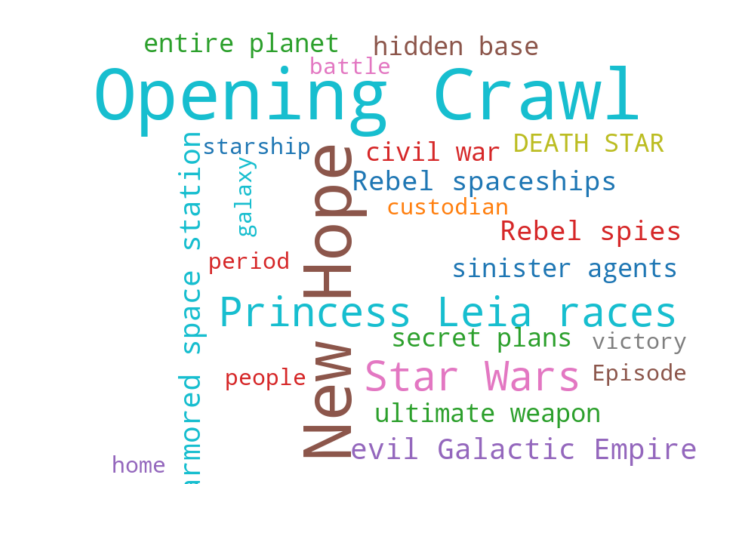

In [93]:
# Visualize keywords by relevance as a wordcloud
from wordcloud import WordCloud

wc_data = { w["text"]: w["relevance"] for w in output["enriched_text"]["keywords"] }
wc = WordCloud(width=400, height=300, scale=2, background_color="white", colormap="Vega10")
wc.generate_from_frequencies(wc_data)  # use precomputed relevance instead of frequencies

plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

Feel free to play with this visualization and improve it. What about using a different metric instead of relevance, e.g. direct word frequencies that the wordcloud library computes by default?

#### Other results

Watson's output also includes processed results from other enrichments that were applied to the text, including entities and taxonomy (what topic or category does this text relate to).

```json
"taxonomy": [
  {
    "label": "/art and entertainment/movies and tv/movies",
    "score": 0.584247,
    "confident": false
  },
  {
    "label": "/society/unrest and war",
    "score": 0.517031,
    "confident": false
  },
  {
    "confident": false,
    "label": "/law, govt and politics/armed forces/army",
    "score": 0.215561
  }
],
```

Get a good sense of all the different pieces of information available in the results. Start thinking about which ones will be useful for looking up answers to questions, and how you might use them.

## 2. Ingest documents

### Create a collection

A _collection_ is used to organize documents of the same kind. For instance, you may want to create a collection of book reviews, or a collection of Wikipedia articles, but it may not make much sense to mix the two groups. This allows Watson to make meaningful inferences over the set of documents, find commonalities and identify important concepts.

Let's create one called "Story Chunks".

In [94]:
# Prepare a collection of documents to use
col, col_id = helper.fetch_object(discovery, "collection", "Story Chunks", environment_id=env_id,
    create=True, create_args=dict(
        environment_id=env_id, configuration_id=cfg_id,
        description="Stories and plots split up into chunks suitable for answering"
    ))
print(json.dumps(col, indent=2))

Created collection: Story Chunks (f1d0e90d-9b71-4561-8e7a-fc4667d9070e)
{
  "name": "Story Chunks",
  "collection_id": "f1d0e90d-9b71-4561-8e7a-fc4667d9070e",
  "description": "Stories and plots split up into chunks suitable for answering",
  "created": "2017-07-15T22:40:52.265Z",
  "updated": "2017-07-15T22:40:52.265Z",
  "configuration_id": "e957aed2-f980-47b9-a995-89a804042300",
  "language": "en",
  "status": "active"
}


Once you have created a collection, you should be able to view it using the Discovery Service tool. To open, go to the **Manage** tab for your service instance, and click the **Launch tool** button.

<img src="images/discovery-manage.png" alt="Discovery service - Manage tab" width="800" />


Here you should see the "Story Chunks" collection you just created.

<img src="images/discovery-tooling.png" alt="Discovery service - Tool showing collections" width="800" />

You can open the collection to view more details about it. If you need to modify configuration options, click the **Switch** link and create a new configuration (the default one cannot be changed).

### Add documents

Okay, now that we have everything set up, let's add a set of "documents" we want Watson to look up answers from, using the Python SDK. Note that Watson treats each "document" as a unit of text that is returned as the result of a query. But we want to retrieve a paragraph of text for each question. So, let's split each file up into individual paragraphs. We will use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library for this purpose.

_**Note**: You could also add and manage documents in the collection using the Discovery tool, but you would have to split paragraphs up into separate files._

_**Note**: We have provided a set of files (`data/Star-Wars/*.html`) with summary plots for Star Wars movies, but you are free to use a collection of your choice. Open one of the files in a text editor to see how the paragraphs are delimited using `<p>...</p>` tags - this is how the code block below split paragraphs into separate "documents"._

In [95]:
# Add documents to collection
doc_ids = []  # to store the generated id for each document added
for filename in glob.glob(os.path.join(data_dir, "Star-Wars", "*.html")):
    print("Adding file:", filename)
    with open(filename, "r") as f:
        # Split each individual <p> into its own "document"
        doc = f.read()
        soup = BeautifulSoup(doc, 'html.parser')
        for i, p in enumerate(soup.find_all('p')):
            doc_info = discovery.add_document(environment_id=env_id, collection_id=col_id,
                file_data=json.dumps({"text": p.get_text(strip=True)}),
                mime_type="application/json",
                metadata={"title": soup.title.get_text(strip=True)})
            doc_ids.append(doc_info["document_id"])
print("Total", len(doc_ids), "documents added.")

Adding file: data\Star-Wars\Episode-III_Revenge-of-the-Sith.html
Adding file: data\Star-Wars\Episode-II_Attack-of-the-Clones.html
Adding file: data\Star-Wars\Episode-IV_A-New-Hope.html
Adding file: data\Star-Wars\Episode-I_The-Phantom-Menace.html
Adding file: data\Star-Wars\Episode-VII_The-Force-Awakens.html
Adding file: data\Star-Wars\Episode-VI_Return-of-the-Jedi.html
Adding file: data\Star-Wars\Episode-V_The-Empire-Strikes-Back.html
Adding file: data\Star-Wars\Rogue-One.html
Total 42 documents added.


If you look at the collection details, you may notice that the `"document_counts"` field now shows some documents as `available` or `processing`. Once processing is complete, you should see all the documents under the `available` count.

In [96]:
# View collection details to verify all documents have been processed
col, col_id = helper.fetch_object(discovery, "collection", "Story Chunks", environment_id=env_id)
print(json.dumps(col, indent=2))

Found collection: Story Chunks (f1d0e90d-9b71-4561-8e7a-fc4667d9070e)
{
  "collection_id": "f1d0e90d-9b71-4561-8e7a-fc4667d9070e",
  "name": "Story Chunks",
  "configuration_id": "e957aed2-f980-47b9-a995-89a804042300",
  "language": "en",
  "status": "active",
  "description": "Stories and plots split up into chunks suitable for answering",
  "created": "2017-07-15T22:40:52.265Z",
  "updated": "2017-07-15T22:40:52.265Z",
  "document_counts": {
    "available": 41,
    "processing": 1,
    "failed": 0
  },
  "training_status": {
    "data_updated": "",
    "total_examples": 0,
    "sufficient_label_diversity": false,
    "processing": false,
    "minimum_examples_added": false,
    "successfully_trained": "",
    "available": false,
    "notices": 0,
    "minimum_queries_added": false
  }
}


So, what did the Discovery service learn? If you list the fields extracted from the set of documents in the collection as part of the enrichment process, you'll see familiar fields like `concepts`, `entities` and `keywords` that were returned in the test analysis.

In [97]:
# List all fields extracted
discovery.list_collection_fields(environment_id=env_id, collection_id=col_id)

{'fields': [{'field': 'f1d0e90d-9b71-4561-8e7a-fc4667d9070e.mappings.document._all.analyzer',
   'type': 'english'},
  {'field': 'enriched_text', 'type': 'nested'},
  {'field': 'extracted_metadata', 'type': 'nested'},
  {'field': 'metadata', 'type': 'nested'},
  {'field': 'text', 'type': 'string'},
  {'field': 'text.analyzer', 'type': 'english'},
  {'field': 'enriched_text.properties.concepts', 'type': 'nested'},
  {'field': 'enriched_text.properties.docSentiment', 'type': 'nested'},
  {'field': 'enriched_text.properties.entities', 'type': 'nested'},
  {'field': 'enriched_text.properties.keywords', 'type': 'nested'},
  {'field': 'enriched_text.properties.language', 'type': 'string'},
  {'field': 'enriched_text.properties.language.analyzer', 'type': 'english'},
  {'field': 'enriched_text.properties.relations', 'type': 'nested'},
  {'field': 'enriched_text.properties.status', 'type': 'string'},
  {'field': 'enriched_text.properties.status.analyzer', 'type': 'english'},
  {'field': 'enric

### Test query

Let's perform a simple query to see if the service can fetch the proper document for us:
> _Look for all paragraphs that have a relation (sentence) with "Jar Jar" as the subject, and return the title and text._


In [98]:
# A simple query
results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "query": "enriched_text.relations.subject.text:\"Luke\",enriched_text.keywords.text:\"father\",enriched_text.keywords.text:\"sister\",enriched_text.concepts.text:\"Leia\"",
        "return": "metadata.title,text"
    })
print(json.dumps(results, indent=2))

{
  "matching_results": 1,
  "results": [
    {
      "id": "57a95bc8-8983-459d-98a9-7a1d86e07652",
      "score": 2.4127808,
      "metadata": {
        "title": "Star Wars: Episode VI - Return of the Jedi"
      },
      "text": "The Rebel Alliance learns that the Empire has been constructing a new Death Star under the supervision of Emperor Palpatine himself. As the station is protected by an energy shield, Han leads a strike team to destroy the shield generator on the forest moon of Endor; doing so would allow a squadron of starfighters to destroy the Death Star. The strike team, accompanied by Luke and Leia, travels to Endor in a stolen Imperial shuttle. On Endor, Luke and his companions encounter a tribe of Ewoks and, after an initial conflict, gain their trust. Later, Luke tells Leia that she is his sister, Vader is their father, and that he must go and confront him. Surrendering to Imperial troops, Luke is brought to Vader and unsuccessfully tries to convince him to turn from t

Change the above query and see what results you get! Try to find one that returns relevant results, and keep that (along with the output) for review.

> See [Query building reference](https://www.ibm.com/watson/developercloud/doc/discovery/query-reference.html) for descriptions of all possible parameters, operators and aggregations. You can also choose to build the query using the web interface (click the "Story Chunks" collection to query it), and then reproduce the query here.

Then answer the questions below:

**Q**: What query did you try? Express it in plain words below.

**A**:
I tried to find in which episode did Luke tell Leia that he is her sister and that vader is their father

**Q**: What answer did you get back from Watson? You only need to mention the relevant snippet of text fro mthe paragraph(s) returned.

**A**: 
The relevant parts are

`title: Star Wars: Episode VI - Return of the Jedi`

 `text: Luke tells Leia that she is his sister, Vader is their father, and that he must go and confront him`



## 3. Parse natural language questions

In order to understand questions posed in natural language, we'll use another Watson service called [Conversation](https://www.ibm.com/watson/developercloud/doc/conversation/index.html). It can be used to design conversational agents or _chatbots_ that exhibit complex behavior, but for the purpose of this project, we'll only use it to parse certain kinds of queries.

### Create a Conversation service instance

Just like you did for the Discovery service, create an instance of the Conversation service. Then launch the associated tool from the service dashboard.

<img src="images/conversation-tooling.png" alt="Conversation service - Tool homepage" width="800" />

A _workspace_ allows you to keep all the items you need for a particular application in one place, just like an _environment_ in case of the Discovery service. Create one called "Bookworm" with a suitable description, such as "I know a lot of stories. Ask me a question!"

<img src="images/conversation-workspace.png" alt="Conversation service - Blank workspace" width="800" />

This should open up a blank workspace, where you can add intents, define the entities you want the agent to idenitfy and structure the overall dialog.

### Add intents

An _intent_ is the goal or purpose of a user's input. Create a set of intents (at least 3) that capture the different kinds of questions that you want the system to answer, e.g. _who_, _what_ and _where_. Along with each intent, add a list of user examples or _utterances_ that map to that intent.

For instance, you could enter the following examples for the _where_ intent:

- Where is the Jedi temple located?
- Where was Luke born?

The Conversation service recommends at least 5 examples for each intent so that Watson learns how to recognize it. These don't have to be very precise, but more examples the better.

<img src="images/conversation-intents.png" alt="Conversation service - Intents listed" width="800" />

Feel free to create your own intents, based on the kinds of questions you want the system to answer, e.g. "How many ...", "What are the most common ..." etc. Each intent will need to be mapped to an appropriate query.

> See [**Defining intents**](https://www.ibm.com/watson/developercloud/doc/conversation/intents.html) for a helpful video and further instructions.

**Q**: What intents did you add to the Conversation service instance?

**A**:
1. who intent
2. what intent
3. where intent


**Q**: Pick one of these intents, and list at least 5 examples for the intent that you entered.

**A**:
the intent is who
the examples given to the service
1. who is Luke's father?
2. who is obi-wan?
3. who leads the rebel forces?
4. who is the commander of storm troops?
5. who is the last jedi?

### Add entities

Once you have your intents set, let's tell the service what entities we want it to identify. One way to do this is using the tool interface, and entering them one-by-one.

> Go to [**Defining entities**](https://www.ibm.com/watson/developercloud/doc/conversation/entities.html) to see how that is done.

But that can be tedious! So let's refer back to the entities that the Discovery service identified, and load them in programmatically.

As before, let's connect to the Conversation service first. Remember to enter your service credentials below.

In [99]:
# Connect to the Conversation service instance
# TODO: Enter your username and password from the Service Credentials tab in service-credentials.json
conversation_creds = helper.fetch_credentials('conversation')
conversation = watson_developer_cloud.ConversationV1(
    version='2017-02-03',
    username=conversation_creds['username'],
    password=conversation_creds['password'])

Fetch the workspace you just created called "Bookworm".

In [100]:
wrk, wrk_id = helper.fetch_object(conversation, "workspace", "Bookworm")
print(json.dumps(wrk, indent=2))

Found workspace: Bookworm (ae57267e-93a3-4ea5-9007-dbcf11d328b4)
{
  "name": "Bookworm",
  "created": "2017-07-11T19:39:02.516Z",
  "updated": "2017-07-15T23:32:19.979Z",
  "language": "en",
  "metadata": null,
  "description": "hi",
  "workspace_id": "ae57267e-93a3-4ea5-9007-dbcf11d328b4",
  "status": "Available"
}


Collect all the entities from the Discovery service collection.

In [101]:
# Get all the entities from the collection and group them by type
response = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "return": "enriched_text.entities.type,enriched_text.entities.text"
    })

# Group individual entities by type ("Person", "Location", etc.)
entities_by_type = {}
for document in response["results"]:
    for entity in document["enriched_text"]["entities"]:
        if entity["type"] not in entities_by_type:
            entities_by_type[entity["type"]] = set()
        entities_by_type[entity["type"]].add(entity["text"])

# Ignore case to avoid duplicates
for entity_type in entities_by_type:
    entities_by_type[entity_type] = {
        e.lower(): e for e in entities_by_type[entity_type]
    }.values()

# Restructure for loading into Conversation workspace
entities_grouped = [{
    "entity": entity_type,
    "values": [{"value": entity} for entity in entities]}
        for entity_type, entities in entities_by_type.items()]
entities_grouped


[{'entity': 'Person',
  'values': [{'value': 'Boba'},
   {'value': 'Palpatine'},
   {'value': 'Anakin'},
   {'value': 'Darth Sidious'},
   {'value': 'Beru Lars'},
   {'value': 'Vader'},
   {'value': 'Han'},
   {'value': 'Mustafar'},
   {'value': 'Viceroy Nute Gunray'},
   {'value': 'PadmÃ©'},
   {'value': 'Darth Vader'},
   {'value': 'Shmi'},
   {'value': 'Geonosis'},
   {'value': 'Cliegg Lars'},
   {'value': 'Mace Windu'},
   {'value': 'Count Dooku'},
   {'value': 'Organa'},
   {'value': 'Supreme Chancellor Palpatine'},
   {'value': 'Anakin Skywalker'},
   {'value': 'Princess Leia'},
   {'value': 'Leia'},
   {'value': 'Polis Massa'},
   {'value': 'Obi-Wan Kenobi'},
   {'value': 'Luke Skywalker'},
   {'value': 'Senator PadmÃ© Amidala'},
   {'value': 'Yoda'},
   {'value': 'Obi-Wan'},
   {'value': 'PadmÃ© Amidala'},
   {'value': 'Jango Fett'},
   {'value': 'Luke'},
   {'value': 'Zam Wesell'},
   {'value': 'Owen'}]},
 {'entity': 'Organization',
  'values': [{'value': 'Confederacy of Indep

Update the workspace with these entities and verify that have been added correctly.

In [102]:
# Add these grouped entities to the Conversation workspace
conversation.update_workspace(workspace_id=wrk_id, entities=entities_grouped)

workspace_details = conversation.get_workspace(workspace_id=wrk_id, export=True)
print(json.dumps(workspace_details["entities"], indent=2))

SSLError: ("bad handshake: SysCallError(-1, 'Unexpected EOF')",)

_**Note**: Ensure that at least 3 entity types, with at least 1 example entity each have been added._

Here is what the list of entities should look like through the Conversation tool.

<img src="images/conversation-entities.png" alt="Conversation service - Entities listed" width="800" />

**Q**: Name 3 entity types that were added, with at least 1 example entity each (e.g. entity type: _City_, example: _Los Angeles_).

**A**: 
1. City example: Coruscant
2. Company example: Jedi Temple
3. FieldTerminology example: the queen

### Design dialog flow

As a final step in creating the Conversation interface, let's design a typical dialog with a user. The most intuitive way to do this is to use the Dialog tab in the tool. Here, you can add _nodes_ that capture different stages in the dialog flow, and connect them in a meaningful way.

Go ahead and add at least 3 dialog nodes. Specify the triggers in terms of the intents and entities that you'd like to match, and an optional intermediate response like "Let me find that out for you." The actual response will be fetched by querying the Discovery service.

Here is what the dialog nodes should look like.

<img src="images/conversation-dialog_nodes.png" alt="Conversation service - Dialog nodes" width="640" />

**Q**: Specify 3 dialog nodes you added, along with the trigger (intent and/or entities) for each.

**A**: 
1. node: Person -- trigger:#who -- response: let me find out who is it
2. node: Location -- trigger:#where
2. node: object -- trigger:#what

### Test dialog

Let's run through a test dialog to demonstrate how the system transitions to one of the nodes you defined above.

In [103]:
# Testing the dialog flow

# Start conversation with a blank message
results = conversation.message(workspace_id=wrk_id, message_input={})
context = results["context"]

# Then ask a sample question
question= "Who is Luke's father?"
results = conversation.message(workspace_id=wrk_id, message_input={
    "text": question,
    "context": context
})
print(json.dumps(results, indent=2))

{
  "intents": [
    {
      "intent": "who",
      "confidence": 1
    }
  ],
  "entities": [
    {
      "entity": "Person",
      "location": [
        7,
        11
      ],
      "value": "Luke",
      "confidence": 1
    }
  ],
  "input": {
    "text": "Who is Luke's father?",
    "context": {
      "conversation_id": "8524396d-845a-4166-aeba-2afd71333e00",
      "system": {
        "dialog_stack": [
          {
            "dialog_node": "root"
          }
        ],
        "dialog_turn_counter": 1,
        "dialog_request_counter": 1,
        "_node_output_map": {
          "Anything else": [
            0
          ]
        },
        "branch_exited": true,
        "branch_exited_reason": "completed"
      }
    }
  },
  "output": {
    "text": [
      "let me find out who is it"
    ],
    "nodes_visited": [
      "Person"
    ],
    "log_messages": []
  },
  "context": {
    "conversation_id": "e048a506-2d81-4f8b-ad36-2efec9b23577",
    "system": {
      "dialog_stack": [


## 4. Query document collection to fetch answers

The Discovery service includes a simple mechanism to make queries against your enriched collection of documents. But you have a lot of control over what fields are searched, how results are aggregated and values are returned.

### Process sample question

Choose a sample nautal language question to ask, and run it through the Conversation service, just like you did above when testing dialog flow.

In [117]:
# TODO: Run a sample question through Conversation service
results = conversation.message(workspace_id=wrk_id, message_input={})
context = results["context"]

# Then ask a sample question
question= "Who is luke's father"
results = conversation.message(workspace_id=wrk_id, message_input={
    "text": question,
    "context": context
})
print(json.dumps(results, indent=2))

{
  "intents": [
    {
      "intent": "who",
      "confidence": 1
    }
  ],
  "entities": [
    {
      "entity": "Person",
      "location": [
        7,
        11
      ],
      "value": "Luke",
      "confidence": 1
    }
  ],
  "input": {
    "text": "Who is luke's father",
    "context": {
      "conversation_id": "74e8e516-0db8-40ae-a682-fe50afbd3db8",
      "system": {
        "dialog_stack": [
          {
            "dialog_node": "root"
          }
        ],
        "dialog_turn_counter": 1,
        "dialog_request_counter": 1,
        "_node_output_map": {
          "Anything else": [
            0
          ]
        },
        "branch_exited": true,
        "branch_exited_reason": "completed"
      }
    }
  },
  "output": {
    "text": [
      "let me find out who is it"
    ],
    "nodes_visited": [
      "Person"
    ],
    "log_messages": []
  },
  "context": {
    "conversation_id": "edf5a776-c8f7-4feb-87dd-85508aac4afb",
    "system": {
      "dialog_stack": [
 

Now extract the intent and entities identified in the question, and optionally what dialog node was triggered (in case you need it later to customize your response). Some sample code is provided below, but you may need to modify it.

In [118]:
# TODO: Identify the intent(s) the user expressed (typically a single one)
query_intents = [intent["intent"] for intent in results["intents"]]
print("Intent(s):", query_intents)

# TODO: Extract the entities found in the question text
query_entities = [entity["value"] for entity in results["entities"]]
print("Entities:", query_entities)

# TODO: (optional) Find out what dialog node was triggered

Intent(s): ['who']
Entities: ['Luke']


### Query the collection

Design a query based on the information extracted above, and run it against the document collection. The sample query provided below simple looks for all the entities in the raw `text` field. Modify it to suit your needs.

Take a look at the [API Reference](https://www.ibm.com/watson/developercloud/discovery/api/v1/?python#query-collection) to learn more about the query options available, and for more guidance see this [documentation page](https://www.ibm.com/watson/developercloud/doc/discovery/using.html).

_**Note**: You may want to design different queries based on the intent / dialog node that was triggered._

In [122]:
# TODO: Query the Discovery service based on the intent and entities
# I added other parts of the questions too to the query
query_results = discovery.query(environment_id=env_id, collection_id=col_id,
    query_options={
        "query": "text:{}".format(",".join("\"{}\"".format(e) for e in query_entities+[x for x in question.split(' ')[2:] if x not in query_entities])),
        "return": "enriched_text.entities.type,enriched_text.entities.text,enriched_text.entities.relevance"
    })
print(json.dumps(query_results, indent=2))

{
  "matching_results": 8,
  "results": [
    {
      "id": "d86f89db-c2f6-45fa-a707-ab7c9d354264",
      "score": 2.039088,
      "enriched_text": {
        "entities": [
          {
            "text": "Luke",
            "type": "Person",
            "relevance": 0.941474
          },
          {
            "text": "Vader",
            "type": "Person",
            "relevance": 0.483592
          },
          {
            "text": "Cloud City",
            "type": "Company",
            "relevance": 0.271107
          },
          {
            "text": "Boba Fett",
            "type": "Person",
            "relevance": 0.194638
          },
          {
            "text": "Anakin Skywalker",
            "type": "Person",
            "relevance": 0.156578
          },
          {
            "text": "Lando",
            "type": "Person",
            "relevance": 0.141476
          },
          {
            "text": "Leia",
            "type": "Person",
            "relevance": 0.141

### Process returned results

If you properly structure the query, Watson is able to do a pretty good job of finding the relevant information. But the result returned is a JSON object. Now your task is to convert that result into an appropriate response that best addresses the original natural language question that was asked.

E.g. if the question was "Who saved Han Solo from Jabba the Hutt?" the answer should ideally just be "The Rebels" and not the entire paragraph describing Han Solo's rescue. But that can be a backup response if you cannot be more specific.

_**Note**: You may have to go back to the previous step and modify the query, especially what you want the Discovery service to return, and this may depend on the intent / dialog node triggered. E.g. study the different parts of a "relation" structure to see how you might construct queries to match them._

In [130]:
# TODO: Process returned results and compose an appropriate response
best_result = max(query_results["results"],key=lambda result: result["score"])
# choose the entity with the most score in the best result that is not in the query entities
# as an answer
answer = max(best_result["enriched_text"]["entities"],
             key=lambda entity: entity['relevance'] if entity['text'] not in query_entities else 0)
print(question)
print(answer['text'])

Who is luke's father
Vader


## 5. Reflections

**Q**: Now that you have gone through this exercise of designing a system that uses two IBM Watson services, what did you learn? What were some of the strengths and weaknesses of this approach?

**A**:
What I learned was

1. setting up a discovery and conversation services
2. working through the API offered by both services
3. visualizing important concepts in documents

The strengths
1. the discovery service offers a good API that could be used to extract sentiment and query documents
2. the conversation service offers a good way to know the intent of users and Entities in a query

The weaknesses
1. The nature of the services require some kind of integration between them and may they should have a been a one service
2. Entities should have been hierarchical it would be beneficial for our case

## (Optional) Extensions

We have provided a set of sample data files containing Star Wars plot summaries. But as mentioned before, you are free to use your own dataset. In fact, a larger dataset maybe more suitable for use with IBM Watson's NLP services. If you used your own dataset, answer the following questions.

**Q**: What dataset did you use, and in what ways is it different from the sample files provided?

**A**:


**Q**: Either include your dataset in the .zip file or repository you submit, or provide clear instructions on how to obtain the dataset, so that your reviewer can run your notebook or inspect the data to verify your results.

**A**: 


_You can also design a web-based application that utilizes these services and deploy that on Bluemix! If you do, please share with your instructors and peers._